In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [49]:
ctwdf = 'CTWD_ProcessData.xlsx'
cvf = 'CV_ProcessData.xlsx'

ctwd = pd.read_excel(ctwdf, usecols=lambda x: 'Unnamed' not in x) # Only import named col
cv = pd.read_excel(cvf, usecols=lambda x: 'Unnamed' not in x)

cv = cv.rename(columns={'value': 'Value'}) # Rename for consistency
ctwd = ctwd.rename(columns={'value': 'Value'})

# Introduction
## Variables

### Common
 - **dateTime**: time for data collection
 - **dataItemId**: Data collection target info
 - **BeadNumber**: Effectively layer
 - **value**: item specified by dataItemId
 - **beadtime (s)**: Length of time since starting that layer (note dwell)
 - **buildTime (s)**: counter since start of data collection
 - **Traverse Speed (mm/s**): Constant in this build - speed of travel 
 - **beadPosition (mm)**: derived measure based on buildTime*Traverse speed. 
 - **MovAvgValue**: Calculated 4 average of value

### CTWD only 
 - Reference value: Only used for CTWD - measure by which Value is offset by
 - ProcessValue_ref: I don't remember what this is

## Preprocessing
- Value outliers were set to NA based on 95% confidence interval
 - This filters for values that are weird at the start of a bead.
- Drop rows where value is NA

In [50]:
cv.dropna(subset=['MovAvgValue', 'Value'], ignore_index=True, inplace=True)
ctwd.dropna(subset=['MovAvgValue', 'Value'], ignore_index=True, inplace=True)

In [115]:
avgroup = test_av.groupby(['Power Setpoint (kW)', 'Dwell Time (s)', 'buildNo','BeadNumber'])
avgroup.mean('Value').isna().sum()

Value                    0
TimeDiff                 0
beadTime (s)             0
buildTime (s)            0
Traverse Speed (mm/s)    0
beadPosition (mm)        0
MovAvgValue              0
dtype: int64

# Statistical Extraction

In [122]:
def extraction(grouped, valuename=None):
    # Extract statistical values for the parts of interest. 
    calc = ['Value', 'MovAvgValue']
    gc = grouped[calc]
    stats = {'mean': gc.mean(),
            'skew': gc.skew(),
            'std': gc.std(),
             'kurt': gc.apply(pd.DataFrame.kurt),
            'count': gc.count()}
    
    keys = list(stats.keys())
    for key in keys:
        stats[key].columns = [f'{key}_' + str(col) for col in stats[key].columns]
    
    joined = stats[keys[0]].join([stats[key] for key in keys[1:]])
    return joined

def buildNo(df):
    # 
    df = df.reset_index(drop=True)
    # Find where BeadNumber goes from 20 to 1. 
    idx = df.index[df['BeadNumber'].diff()==-19]  # Modify based off of layers 
    df['buildNo'] = 11 # 11 is the last build 
    start = 0 # initial build no. 
    for no, i  in enumerate(idx): 
        end = i
        df.loc[start:end, 'buildNo'] = no
        start=end
    return df

## Current / Voltage

In [140]:
def preprocess(df, name=None, drop=None, group=None):
    if name is not None:
        sub = df.loc[df['dataItemId']=='Arc Current']
    else:
        sub = df
    #sub = buildNo(sub)
    if drop is not None:
        av_cv = cv.drop(columns=drop, errors='ignore')
    if group is not None:
        sub = sub.groupby(by=group)
        return extraction(sub) # statistical extract
    else: 
        # sub.groupby('buildNo').count() # validate group sizes are correct
        return sub

gp = ['Power Setpoint (kW)', 'Dwell Time (s)', 'BeadNumber']
arcrm =  ['Traverse Speed (mm/s)', 'buildTime (s)', 'beadTime (s)',
          'dateTime', 'TimeDiff', 'beadPosition (mm)']

av_stat = preprocess(cv, name="Arc Voltage", drop=arcrm, group=gp)
ac_stat = preprocess(cv, name="Arc Current", drop=arcrm, group=gp)
ctwd_stat = preprocess(ctwd, drop= arcrm+['dataItemId','ReferenceValue'], group=gp)

In [ ]:
# Per bead
for bead in range(InputDataFrame['BeadNumber'].max()+1-InputDataFrame['BeadNumber'].min()):

    # Parse out bead data
    BeadData = InputDataFrame[InputDataFrame['BeadNumber'] == bead+1]

    # Determine if bead averages (ie PacketLength='average' therefore one packet is used) is desired
    if len(BeadData['PacketNumber']) == 2:

        # Parse out packet data
        PacketData = BeadData[BeadData['PacketNumber'] == 1]

        # Parse out current and voltage
        PacketCurrent = PacketData[PacketData['PacketDataItemId'] == 'Arc Current']['PacketAvgValue'].values[0]
        PacketVoltage = PacketData[PacketData['PacketDataItemId'] == 'Arc Voltage']['PacketAvgValue'].values[0]

        # Parse out position and bead time interval
        PacketTimeInterval = PacketData['PacketBeadTimeMax (s)'].values[0] - PacketData['PacketBeadTimeMin (s)'].values[0]
        PacketPositionInterval = PacketData['PacketBeadPositionMax (mm)'].values[0] - PacketData['PacketBeadPositionMin (mm)'].values[0]

        # Check if value reference conversion is on
        if ValueRef == "on":

            # Save first bead value for reference
            if bead+1 == 1:

                # Calculate power (Watts)
                PacketData['Power (W)'] = PacketCurrent*PacketVoltage
                RefPower = PacketCurrent*PacketVoltage
                PacketData['RefValue_Power'] = RefPower

                # Calculate linear energy density (LED) in J/mm
                PacketData['LED (J/mm)'] = (PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval
                RefLED = (PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval
                PacketData['RefValue_LED'] = RefLED

            else:
                PacketData['Power (W)'] = PacketCurrent*PacketVoltage
                PacketData['LED (J/mm)'] = ((PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval)
                PacketData['RefValue_Power'] = RefPower
                PacketData['RefValue_LED'] = RefLED

                PacketData['Power_ProcessRef'] = PacketData['Power (W)'] - RefPower
                PacketData['LED_ProcessRef'] = PacketData['LED (J/mm)'] - RefLED

        if ValueRef == "off":
            # Calculate power (Watts)
            PacketData['Power (W)'] = PacketCurrent*PacketVoltage

            # Calculate linear energy density (LED) in J/mm
            PacketData['LED (J/mm)'] = (PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval

        # Save dataframe
        OutputDataFrame = pd.concat([OutputDataFrame, PacketData])


In [ ]:
def Power_LED_Calc(InputDataFrame, SingleBeadToggle, ValueRef):

OutputDataFrame = pd.DataFrame()

# Per packet
for packet in range(BeadData['PacketNumber'].max()+1-BeadData['PacketNumber'].min()):

    # Parse out packet data
    PacketData = BeadData[BeadData['PacketNumber'] == packet+1]

    # Parse out current and voltage
    PacketCurrent = PacketData[PacketData['PacketDataItemId'] == 'Arc Current']['PacketAvgValue'].values[0]
    PacketVoltage = PacketData[PacketData['PacketDataItemId'] == 'Arc Voltage']['PacketAvgValue'].values[0]

    # Parse out position and bead time interval
    PacketTimeInterval = PacketData['PacketBeadTimeMax (s)'].values[0] - PacketData['PacketBeadTimeMin (s)'].values[0]
    PacketPositionInterval = PacketData['PacketBeadPositionMax (mm)'].values[0] - PacketData['PacketBeadPositionMin (mm)'].values[0]

    # Check if value reference conversion is on
    if ValueRef == "on":

        # Save first bead value for reference
        if bead+1 == 1:

            # Calculate power (Watts)
            PacketData['Power (W)'] = PacketCurrent*PacketVoltage
            # PacketData['RefValue_Power'] = RefPower

            # Calculate linear energy density (LED) in J/mm
            PacketData['LED (J/mm)'] = (PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval
            # PacketData['RefValue_LED'] = RefLED

        else:
            PacketData['Power (W)'] = PacketCurrent*PacketVoltage
            PacketData['LED (J/mm)'] = ((PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval)
            PacketData['RefValue_Power'] = RefPower
            PacketData['RefValue_LED'] = RefLED

            PacketData['Power_ProcessRef'] = PacketData['Power (W)'] - RefPower
            PacketData['LED_ProcessRef'] = PacketData['LED (J/mm)'] - RefLED

    if ValueRef == "off":
        # Calculate power (Watts)
        PacketData['Power (W)'] = PacketCurrent*PacketVoltage

        # Calculate linear energy density (LED) in J/mm
        PacketData['LED (J/mm)'] = (PacketCurrent*PacketVoltage*PacketTimeInterval)/PacketPositionInterval

    # Save dataframe
    OutputDataFrame = pd.concat([OutputDataFrame, PacketData])

# Calculate reference power and LED
if ValueRef == "on":

    # Save first bead value for reference
    if bead+1 == 1:
        RefPower = OutputDataFrame['Power (W)'].mean()
        OutputDataFrame['RefValue_Power'] = RefPower
        OutputDataFrame['Power_ProcessRef'] = 0

        RefLED = OutputDataFrame['LED (J/mm)'].mean()
        OutputDataFrame['RefValue_LED'] = RefLED
        OutputDataFrame['LED_ProcessRef'] = 0

## Merge dataframes

In [152]:
def rename_values(df, val):
    df.columns = [x.replace("Value", val) for x in df.columns]
    return df

arcCurrent = rename_values(ac_stat, "Current")
arcVoltage = rename_values(av_stat, "Voltage")
contactTipWD = rename_values(ctwd_stat, "CTWD")

merged_stats = arcCurrent.join([arcVoltage, contactTipWD])
merged_stats.to_csv('merged_beadnumber.csv')

In [155]:
merged_stats.isna().sum()

mean_Current           0
mean_MovAvgCurrent     0
skew_Current           0
skew_MovAvgCurrent     0
std_Current            0
std_MovAvgCurrent      0
kurt_Current           0
kurt_MovAvgCurrent     0
count_Current          0
count_MovAvgCurrent    0
mean_Voltage           0
mean_MovAvgVoltage     0
skew_Voltage           0
skew_MovAvgVoltage     0
std_Voltage            0
std_MovAvgVoltage      0
kurt_Voltage           0
kurt_MovAvgVoltage     0
count_Voltage          0
count_MovAvgVoltage    0
mean_CTWD              0
mean_MovAvgCTWD        0
skew_CTWD              0
skew_MovAvgCTWD        0
std_CTWD               0
std_MovAvgCTWD         0
kurt_CTWD              0
kurt_MovAvgCTWD        0
count_CTWD             0
count_MovAvgCTWD       0
dtype: int64

In [83]:
cvg = cv.drop(columns=remove, errors='ignore')
cvg = cvg.groupby('dataItemId')
aC, aV = cvg.get_group("Arc Current"), cvg.get_group("Arc Voltage")
aC = aC.drop(columns=['dataItemId'], errors='ignore')
aV = aV.drop(columns=['dataItemId'],  errors='ignore')

In [268]:
pktno = 4 # packets per bead
target = cv.loc[cv.dataItemId=='Arc Current']
grouped = target.groupby(['Power Setpoint (kW)', 'Dwell Time (s)', 'BeadNumber'])
# Segment
pktTime = (grouped['buildTime (s)'].max() - grouped['buildTime (s)'].min()) / pktno

bins = np.array([])
for idx, segment in enumerate(pktTime):
    segment = round(segment, 3)
    startval = grouped['buildTime (s)'].min().iloc[idx]
    endval = grouped['buildTime (s)'].max().iloc[idx]
    pd.Interval(b[i], b[i+1], closed='left' for i in np.arange()
    
for i in range(len(bins)-1):
    if (bins[i] >= bins[i+1]):
        print(i, bins[i], bins[i+1])
    
    #intervals = [pd.Interval(bins[i], bins[i+1], closed='left') for i in range(len(bins)-1)]

#pd.cut(grouped['buildTime (s)'], bins=bins, right=False)

# Cut the dataframe based on these bins and group by
#df['time_bins'] = pd.cut(df['buildTime (s)'], bins=bins, right=False)


90 663.758 0.907
181 858.198 0.505
270 1227.7949999999998 0.5990000000000001
360 1798.5639999999996 0.505
452 573.125 0.912
541 858.143 0.303
631 1148.7459999999999 0.507
717 1718.9199999999996 0.808
808 663.828 0.303
899 858.1729999999999 0.404
991 1233.2370000000003 0.611


In [84]:
def packetize(df0, pktno):
    # Subdivide 
    # pktno: no. of packets to divide each bead into
    df = df0.copy()
    dfg = df.groupby('BeadNumber')
    packet_sizes = (df.groupby('BeadNumber').size() / pktno).apply(np.ceil).astype(int)
    df['CumCount'] = df.groupby('BeadNumber').cumcount()
    df['PktGp'] = df.groupby('BeadNumber').apply(lambda x: x['CumCount'] // packet_sizes[x.name] + 1).reset_index(level=0, drop=True)
    df['Packet'] = (df['BeadNumber'] - 1) * pktno + df['PktGp']
    df.drop(columns=['CumCount', 'PktGp'], inplace=True)
    return df

def packetize_and_analyze(target, pktno):
    pk_target = packetize(target, pktno)
    tgt_gp = pk_target.groupby(['Packet', 'Power Setpoint (kW)', 'Dwell Time (s)'])
    bn = tgt_gp.count()['BeadNumber']
    tgt_stats = extraction(tgt_gp)
    return tgt_stats, bn
    #return tgt_stats.join(bn)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [161]:
cv

,dateTime,dataItemId,BeadNumber,Value,TimeDiff,beadTime (s),buildTime (s),Traverse Speed (mm/s),beadPosition (mm),MovAvgValue,Power Setpoint (kW),Dwell Time (s)
0,2023-02-15 21:18:32.288,Arc Current,1,193.1,0.0,0.304,0.304,6.773333,2.059093,176.400000,1.5,0
1,2023-02-15 21:18:32.388,Arc Current,1,155.6,0.0,0.404,0.404,6.773333,2.736427,169.466667,1.5,0
2,2023-02-15 21:18:32.489,Arc Current,1,130.3,0.0,0.505,0.505,6.773333,3.420533,159.675000,1.5,0
3,2023-02-15 21:18:32.790,Arc Current,1,188.6,0.0,0.806,0.806,6.773333,5.459307,158.166667,1.5,0
4,2023-02-15 21:18:32.895,Arc Current,1,181.1,0.0,0.911,0.911,6.773333,6.170507,166.666667,1.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
105121,2023-02-15 20:37:54.228,Arc Voltage,20,19.4,0.0,22.154,1803.416,6.773333,150.056427,19.200000,2.1,60
105122,2023-02-15 20:37:54.324,Arc Voltage,20,18.2,0.0,22.250,1803.512,6.773333,150.706667,18.820000,2.1,60
105123,2023-02-15 20:37:54.425,Arc Voltage,20,21.1,0.0,22.351,1803.613,6.773333,151.390773,19.060000,2.1,60
105124,2023-02-15 20:37:54.525,Arc Voltage,20,19.3,0.0,22.451,1803.713,6.773333,152.068107,19.380000,2.1,60


In [160]:
def Packetize(InputDataFrame, PacketLength, MovAvgWindowSize, SingleBeadToggle):

    OutputDataFrame = pd.DataFrame()

    if SingleBeadToggle == 0:
        for bead in df.BeadNumber.unique():
            BeadData = InputDataFrame[InputDataFrame['BeadNumber'] == bead+1]
            if PacketLength == "average":

                # Convert packet list entry to dataframe
                Packet_DF = pd.DataFrame(BeadData)

                Packet_Data = []

                # Apply moving average filter to each packet
                Packet_DF['PacketMovAvgValue'] = Packet_DF["value"].rolling(MovAvgWindowSize, min_periods=2).mean()

                # Calculate average value for each packet
                Packet_DF['PacketAvgValue'] = Packet_DF["PacketMovAvgValue"].mean()

                # Assign packet number
                PacketNumber = 1

                # Create dataframe containing: lowest bead time in packet, lowest build time in packet, dataitem ID, packet value
                Packet_Data.append([np.array(Packet_DF['BeadNumber'])[0], PacketNumber,
                                    Packet_DF['dateTime'].values[0], Packet_DF['dateTime'].values[-1],
                                    Packet_DF['buildTime (s)'].min(), Packet_DF['buildTime (s)'].max(),
                                    Packet_DF['beadTime (s)'].min(), Packet_DF['beadTime (s)'].max(),
                                    Packet_DF["beadPosition (mm)"].min(), Packet_DF['beadPosition (mm)'].max(),
                                    np.array(Packet_DF['dataItemId'])[0], np.array(Packet_DF['PacketAvgValue'])[0]])

            else:
                # Split bead data based on length of packet time interval
                PacketList = np.array_split(BeadData, np.ceil(int(BeadData['beadTime (s)'].max() - BeadData['beadTime (s)'].min())/PacketLength))

                Packet_Data = []

                # Iterate through packets
                for packet in range(len(PacketList)):

                    # Convert packet list entry to dataframe
                    Packet_DF = pd.DataFrame(PacketList[packet])

                    # Assign packet number
                    PacketNumber = packet+1

                    # Apply moving average filter to each packet
                    Packet_DF_MovAvgWindow = Packet_DF["value"].rolling(MovAvgWindowSize, min_periods=2).mean()

                    # Calculate average value for each packet
                    Packet_DF['PacketAvgValue'] = Packet_DF_MovAvgWindow.mean()

                    # Create dataframe containing: lowest bead time in packet, lowest build time in packet, dataitem ID, packet value
                    Packet_Data.append([np.array(Packet_DF['BeadNumber'])[0], PacketNumber,
                                        Packet_DF['dateTime'].values[0], Packet_DF['dateTime'].values[-1],
                                        Packet_DF['buildTime (s)'].min(), Packet_DF['buildTime (s)'].max(),
                                        Packet_DF['beadTime (s)'].min(), Packet_DF['beadTime (s)'].max(),
                                        Packet_DF["beadPosition (mm)"].min(), Packet_DF['beadPosition (mm)'].max(),
                                        np.array(Packet_DF['dataItemId'])[0], np.array(Packet_DF['PacketAvgValue'])[0]])


            # Add to output data frame
            OutputDataFrame = pd.concat([OutputDataFrame, pd.DataFrame(Packet_Data, columns=['BeadNumber', 'PacketNumber',
                                                                                             'PacketDateTimeMin', 'PacketDateTimeMax',
                                                                                             'PacketBuildTimeMin (s)', 'PacketBuildTimeMax (s)',
                                                                                             'PacketBeadTimeMin (s)', 'PacketBeadTimeMax (s)',
                                                                                             'PacketBeadPositionMin (mm)', 'PacketBeadPositionMax (mm)',
                                                                                             'PacketDataItemId', 'PacketAvgValue'])])
    return OutputDataFrame


In [ ]:
def Packetize(dfi, PktLength, MovAvgWindowSize, SingleBeadToggle):
    def process_avg_pkt(bead_data):
        bead_data['PktMovAvgValue'] = bead_data["value"].rolling(MovAvgWindowSize, min_periods=2).mean()
        bead_data['PktAvgValue'] = bead_data["PktMovAvgValue"].mean()
        return bead_data.iloc[0]

    def process_pktize(bead_data, PktLength):
        bead_data['PktNum'] = ((bead_data['beadTime (s)'] - bead_data['beadTime (s)'].min()) // PktLength).astype(int)
        
        grouped_pkt = bead_data.groupby('PktNum').agg({
            'BeadNumber': 'first',
            'dateTime': ['min', 'max'],
            'buildTime (s)': ['min', 'max'],
            'beadTime (s)': ['min', 'max'],
            'beadPosition (mm)': ['min', 'max'],
            'dataItemId': 'first',
            'value': lambda x: x.rolling(MovAvgWindowSize, min_periods=2).mean().mean()
        }).reset_index()
        
        return grouped_pkt

    if SingleBeadToggle == 0:

        if PktLength == "average":
            dfo = dfi.groupby('BeadNumber').apply(process_avg_pkt).reset_index(drop=True)
        else:
            OutputPkts = []
            for _, bead_data in dfi.groupby('BeadNumber'):
                OutputPkts.append(process_pktize(bead_data, PktLength))
            
            dfo = pd.concat(OutputPkts, ignore_index=True)
        
        # Fix column names if using aggregation
        if PktLength != "average":
            dfo.columns = ['PktNumber', 'BeadNumber', 'PktDateTimeMin', 'PktDateTimeMax', 
                           'PktBuildTimeMin (s)', 'PktBuildTimeMax (s)', 
                           'PktBeadTimeMin (s)', 'PktBeadTimeMax (s)', 
                           'PktBeadPositionMin (mm)', 'PktBeadPositionMax (mm)', 
                           'PktDataItemId', 'PktAvgValue']

    return dfo


# Save files
## Save Packeted Values

In [252]:
pkt = 10 #
test, tbn = packetize_and_analyze(aC,10)#.to_csv(f'arcCurrent_pkt{pkt}.csv')
tbn

Packet  Power Setpoint (kW)  Dwell Time (s)
1       1.5                  0                 218
                             15                 42
2       1.5                  15                177
                             30                 83
3       1.5                  30                135
                                              ... 
198     2.1                  15                140
199     2.1                  15                 82
                             30                182
200     2.1                  30                 36
                             60                222
Name: BeadNumber, Length: 419, dtype: int64

# Plotting

KeyError: 'std_MovAvgCurrent'

<Figure size 1000x600 with 0 Axes>

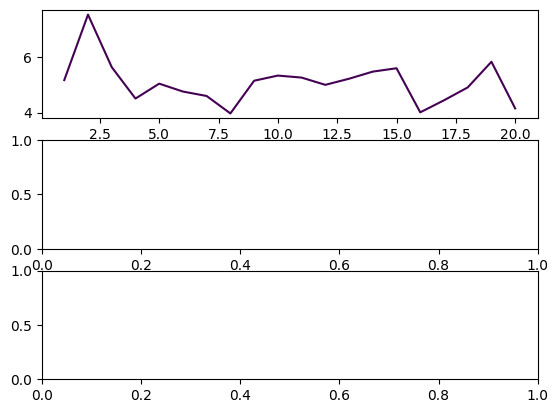

In [168]:
import numpy as np
import matplotlib.lines as mlines

powers = cv['Power Setpoint (kW)'].unique()
dwell_times = cv['Dwell Time (s)'].unique()
graphby = 'std_MovAvgCurrent'
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(powers)))
lss = ['solid', 'dotted', 'dashed', 'dashdot']
color_lines = []
ls_lines = []
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
for ddx, dT in enumerate(dwell_times):    
    for idx, power in enumerate(powers):
        aC = arcCurrent.loc[(power, dT, slice(None)), :].reset_index()
        aV = arcVoltage.loc[(power, dT, slice(None)), :].reset_index()
        CTWD = contactTipWD.loc[(power, dT, slice(None)), :].reset_index()
        ax1.plot(aC['BeadNumber'], aC[graphby], color=colors[idx], linestyle=lss[ddx])
        ax2.plot(aV['BeadNumber'], aV[graphby], color=colors[idx], linestyle=lss[ddx])
        ax3.plot(CTWD['BeadNumber'], CTWD[graphby], color=colors[idx], linestyle=lss[ddx])

        if ddx == 0:
            color_lines.append(mlines.Line2D([], [], color=colors[idx], label=f'{power} kW'))
        if idx == 0:
            ls_lines.append(mlines.Line2D([], [], color='black', linestyle=lss[ddx], label=f'{dT} sec.'))

# Add the legends to one of the axes (or all of them if desired)
ax1.legend(handles=color_lines, bbox_to_anchor=(1, 1), title='Power')
ax2.legend(handles=ls_lines, bbox_to_anchor=(1, 1), title='Dwell Time')

fig.suptitle(graphby)
ax1.set_xticks([]), ax2.set_xticks([])
plt.xlabel('BeadNumber')
plt.xticks(np.arange(1,21))
ax1.set_ylabel('Arc Current (A)'), ax2.set_ylabel('Arc Voltage (V)')
ax3.set_ylabel('CTWD')
plt.tight_layout()
plt.savefig(f'{graphby}.png', dpi=300)
